# This workbook will look into the highest and lowest overall team KD, damage and damage/kill for both wins and losses

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from cdl_helper import read_in_all_matches, CDL_PALETTE

df = read_in_all_matches()
df.sample(3)

,gameMap,gameMode,id,programId,firstName,lastName,alias,headshot,socialNetworkHandles,averageSpeed,...,matchGame.gameMap.publishDetails.time,matchGame.gameMap.publishDetails.user,matchGameResult.hostGameScore,matchGameResult.guestGameScore,matchGameResult.winnerTeamId,matchGameResult.loserTeamId,event,setting,totalHeadshots,totalTiersCaptured
33,Embassy,CDL SnD,29,2,Benjamin,Bance,Bance,https://www.callofduty.com/content/dam/activis...,"[{'socialNetworkType': 'TWITTER', 'handle': 'h...",90.994438,...,2022-12-05T10:03:55.939Z,blte5475d8d4c1a4efe,5.0,6.0,12.0,13.0,M2Event,lan,NaN,NaN
8,El Asilo,CDL SnD,93,2,Adam,Garcia,Assault,https://www.callofduty.com/content/dam/activis...,"[{'socialNetworkType': 'TWITTER', 'handle': 'h...",105.231247,...,2022-12-05T10:02:49.938Z,blte5475d8d4c1a4efe,5.0,6.0,9.0,11.0,M2Qual,online,NaN,NaN
19,Al Bagra Fortress,CDL Control,264,2,Jamie,Craven,Insight,https://www.callofduty.com/content/dam/activis...,[],168.411057,...,2022-12-05T10:03:45.339Z,blte5475d8d4c1a4efe,0.0,3.0,17.0,9.0,M2Qual,online,NaN,NaN


I first need to assign winners and losers

In [2]:
df['map_winner'] = ["host" if a > b else "guest" for a, b in zip(df['matchGameResult.hostGameScore'], df['matchGameResult.guestGameScore'])]

df['is_winner'] = [1 if a == b else 0 for a, b in zip(df['map_winner'], df['team_type'])]

In [3]:
hp = df[df['gameMode']=='CDL Hardpoint']
hp.gameMode.unique()

array(['CDL Hardpoint'], dtype=object)

In [4]:
hp = hp[['alias', 'abbrev', 'gameMap', 'oppo_abbrev', 'matchGame.matchId', 'totalKills', 'totalDeaths', 'totalDamageDealt', 'totalShotsFired', 'totalShotsHit', 'is_winner', 'event']]
hp.sample(4)

,alias,abbrev,gameMap,oppo_abbrev,matchGame.matchId,totalKills,totalDeaths,totalDamageDealt,totalShotsFired,totalShotsHit,is_winner,event
30,SlasheR,ATL,Zarqwa Hydroelectric,LAT,8641,20.0,22.0,2554.0,330.0,96.0,0,M1Qual
3,Octane,LAT,Mercado Las Almas,ATL,8727,23.0,22.0,3039.0,337.0,118.0,1,M3Qual
4,Nero,BOS,Al Bagra Fortress,TOR,8721,29.0,26.0,3178.0,397.0,118.0,0,M3Qual
4,Exceed,LAG,Embassy,ATL,8700,28.0,27.0,3701.0,511.0,142.0,1,M2Qual


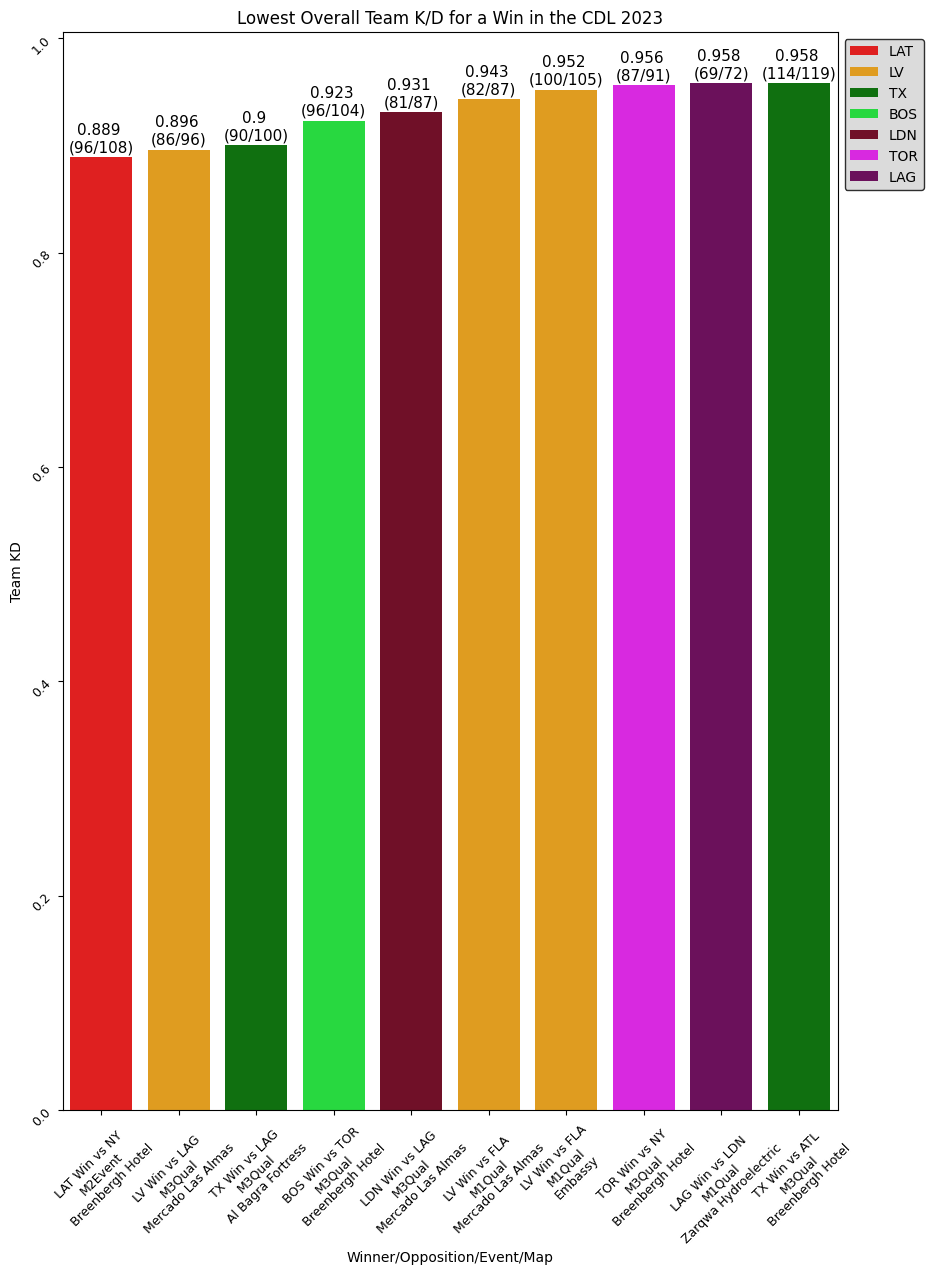

In [5]:

refined = hp[['abbrev', 'matchGame.matchId', 'totalKills', 'totalDeaths', 'oppo_abbrev', 'is_winner', 'gameMap', 'event']]
grouped = refined.groupby(['abbrev', 'oppo_abbrev', 'matchGame.matchId', 'gameMap', 'event']).sum().reset_index()
grouped['team_kd'] = (grouped['totalKills']/grouped['totalDeaths']).round(3)

wins = grouped[grouped['is_winner']> 0].copy()

wins.sort_values('team_kd', ascending=True, inplace=True);
wins['matchDesc'] = [f"{a} Win vs {b} \n{ev}\n{map_}" for a, b, ev, map_ in zip(wins['abbrev'], wins['oppo_abbrev'], wins['event'], wins['gameMap'])]
wins = wins[wins['totalKills']!=0]

fig = plt.figure(figsize=(10, 14))
ax1 = fig.subplots()

lowest_10 = wins[['matchDesc','abbrev', 'team_kd', 'totalKills', 'totalDeaths']].iloc[0:10]
sns.barplot(data=lowest_10, x='matchDesc', y='team_kd', hue='abbrev', palette=CDL_PALETTE, dodge=False)
frame = ax1.legend(bbox_to_anchor=(1, 1)).get_frame()
frame.set_color('lightgrey')
frame.set_edgecolor('black')
ax1.tick_params(rotation=45, labelsize=9)
ax1.set_ylabel("Team KD")
ax1.set_xlabel("Winner/Opposition/Event/Map")
for x, y, kill, death in zip(ax1.get_xticks(), lowest_10['team_kd'], lowest_10['totalKills'], lowest_10['totalDeaths']):
    ax1.text(x, y+0.005, f"{y} \n({int(kill)}/{int(death)})", horizontalalignment='center', fontsize=11)
ax1.set_title("Lowest Overall Team K/D for a Win in the CDL 2023");

Text(0.5, 1.0, 'Highest Overall Team K/D for a Win in the CDL 2023')

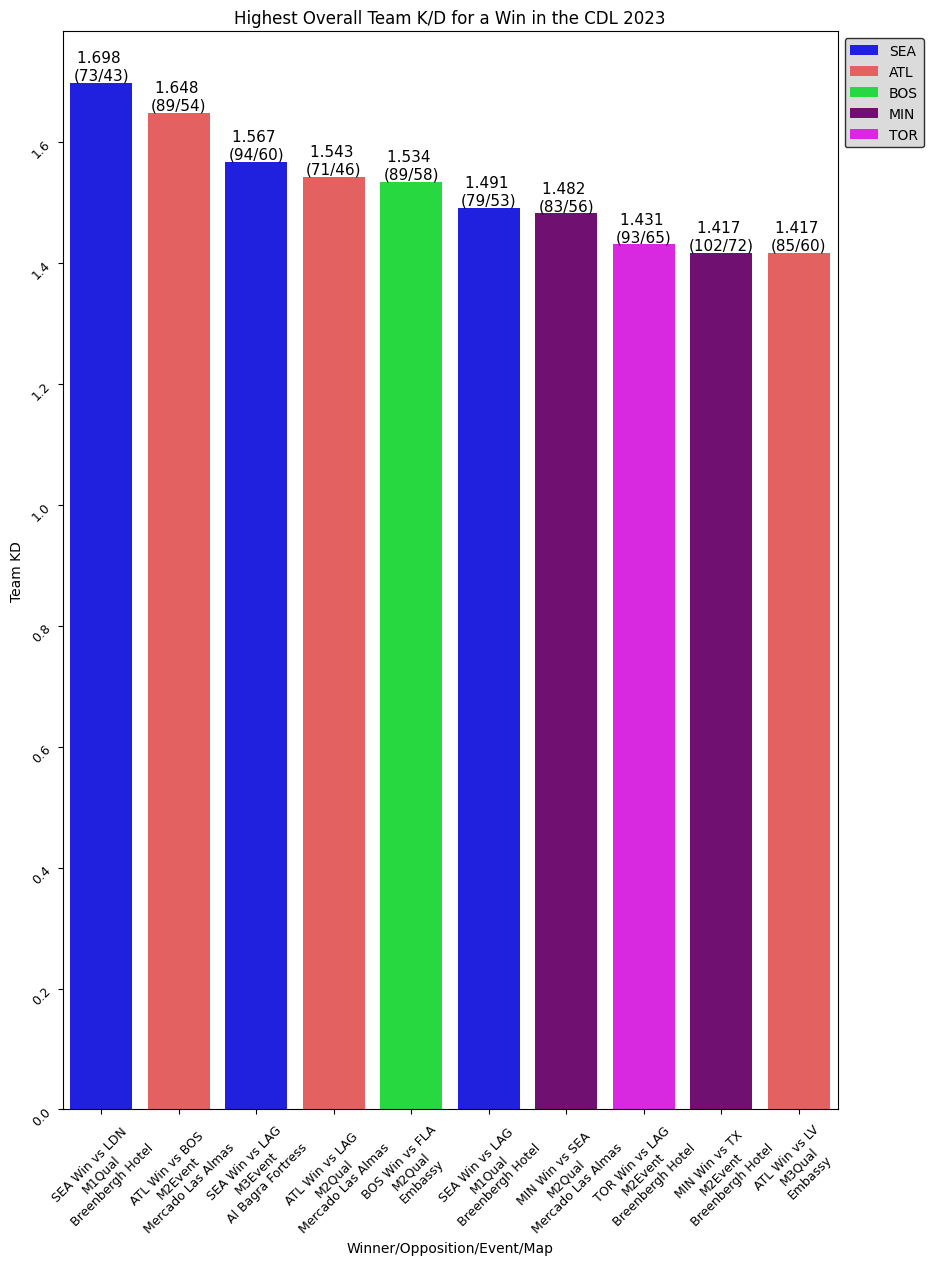

In [6]:
fig = plt.figure(figsize=(10, 14))
ax1 = fig.subplots()

lowest_10 = wins[['matchDesc','abbrev', 'team_kd', 'totalDeaths', 'totalKills']].iloc[-10:].sort_values('team_kd', ascending=False)
sns.barplot(data=lowest_10, x='matchDesc', y='team_kd', hue='abbrev', palette=CDL_PALETTE, dodge=False)
frame = ax1.legend(bbox_to_anchor=(1, 1)).get_frame()
frame.set_color('lightgrey')
frame.set_edgecolor('black')
ax1.tick_params(rotation=45, labelsize=9)
ax1.set_ylabel("Team KD")
ax1.set_xlabel("Winner/Opposition/Event/Map")
for x, y, kill, death in zip(ax1.get_xticks(), lowest_10['team_kd'], lowest_10['totalKills'], lowest_10['totalDeaths']):
    ax1.text(x, y+0.005, f"{y} \n({int(kill)}/{int(death)})", horizontalalignment='center', fontsize=11)
ax1.set_title("Highest Overall Team K/D for a Win in the CDL 2023")